In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [17]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [18]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

In [19]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [20]:
%matplotlib inline 

In [21]:
from matplotlib import pyplot as plt

In [22]:
img, label = test_data[0]

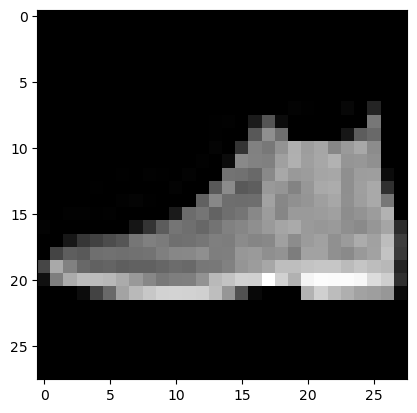

In [23]:
plt.imshow(img.squeeze(), cmap="gray")

In [24]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [25]:
labels_map[label]

'Ankle Boot'

In [26]:
# mps in our case 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [27]:
class NNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# moving the model to relevant device
model = NNetwork().to(device)
print(model)

NNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation. Actually, this is batch gradient descent, stochastic if batch_size=1
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------
loss: 2.302197  [   64/60000]
loss: 2.142169  [ 6464/60000]
loss: 1.740829  [12864/60000]
loss: 1.462694  [19264/60000]
loss: 1.119887  [25664/60000]
loss: 1.026672  [32064/60000]
loss: 0.993075  [38464/60000]
loss: 0.861004  [44864/60000]
loss: 0.872928  [51264/60000]
loss: 0.810578  [57664/60000]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.788189 

Epoch 2
-----------------------
loss: 0.790266  [   64/60000]
loss: 0.860051  [ 6464/60000]
loss: 0.577830  [12864/60000]
loss: 0.779416  [19264/60000]
loss: 0.664191  [25664/60000]
loss: 0.628859  [32064/60000]
loss: 0.704813  [38464/60000]
loss: 0.676982  [44864/60000]
loss: 0.706171  [51264/60000]
loss: 0.641670  [57664/60000]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.630983 

Epoch 3
-----------------------
loss: 0.556932  [   64/60000]
loss: 0.659861  [ 6464/60000]
loss: 0.429121  [12864/60000]
loss: 0.664406  [19264/60000]
loss: 0.582425  [25664/60000]
loss: 0.551107  [32064/60000]
loss: 0.584539  [384

In [51]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
for k in range(20):
    x, y = test_data[k][0], test_data[k][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"') 

Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Shirt", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Coat", Actual: "Coat"
Predicted: "Shirt", Actual: "Shirt"
Predicted: "Sandal", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"
Predicted: "Coat", Actual: "Coat"
Predicted: "Sandal", Actual: "Sandal"
Predicted: "Sandal", Actual: "Sneaker"
Predicted: "Dress", Actual: "Dress"
Predicted: "Coat", Actual: "Coat"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Shirt", Actual: "Coat"
Predicted: "Bag", Actual: "Bag"
Predicted: "T-shirt/top", Actual: "T-shirt/top"
